In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# sns.set(style="whitegrid", palette="muted", font_scale=1.5)
sns.set()
import holidays
us_holidays = holidays.US()

# 1
## Data Preprocessing

First, we load the raw data and get rid of some of the columns. We only care about price, so we include that. Percent change is recalculated as log (to ensure no error in data).

We might predict on percent change due to benefit of stationarity for time series models.
Update: This didn't turn out well and the models reqiured a LOT more time for tuning. This was disregarded.

In [2]:
raw_data = pd.read_csv('data/raw_data.csv')
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data = raw_data.sort_values(by='Date')

# drop volume
raw_data = raw_data.drop(columns=['Vol.'])

# from what is discussed, we only care about "price". Open, High, Low, and Change % will be dropped as well
raw_data = raw_data.drop(columns=['Open', 'High', 'Low', 'Change %'])

raw_data['LogPercentChange'] = np.log(raw_data['Price'] / raw_data['Price'].shift(1))
raw_data = raw_data.iloc[1:,:].reset_index(drop=True)

# Show the resulting data
display(raw_data.head())

,Date,Price,LogPercentChange
0,2007-12-04,498.519,-0.011147
1,2007-12-05,493.834,-0.009442
2,2007-12-06,509.300,0.030838
3,2007-12-07,498.294,-0.021847
4,2007-12-10,496.023,-0.004568


## Graphing

This is graphing for me to get a sense of the data, not so much for the project itself.

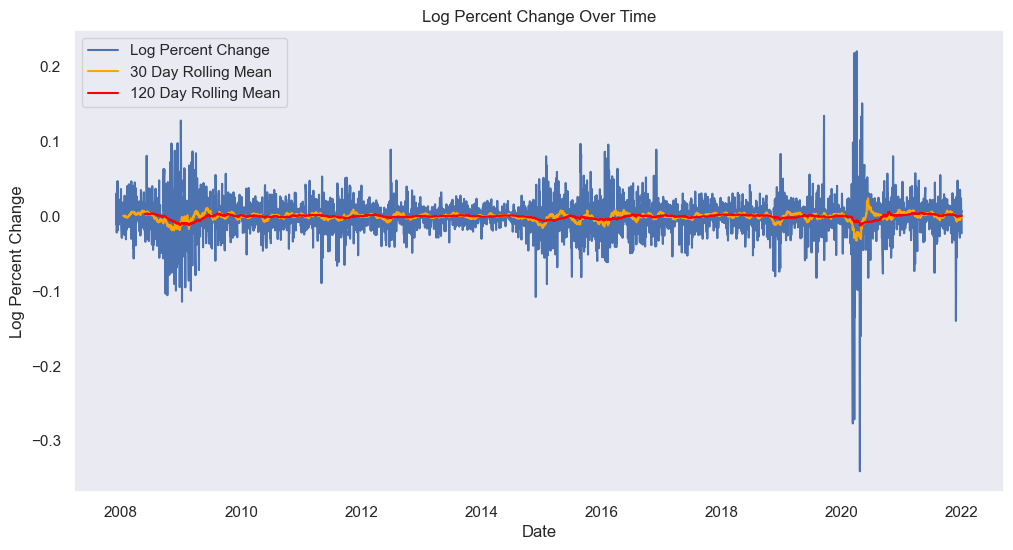

In [3]:
# plot LogPercentChange
plt.figure(figsize=(12, 6))
plt.plot(raw_data['Date'], raw_data['LogPercentChange'], label='Log Percent Change')
# plot rolling mean 30 days and 120 days
plt.plot(raw_data['Date'], raw_data['LogPercentChange'].rolling(30).mean(), label='30 Day Rolling Mean', color='orange')
plt.plot(raw_data['Date'], raw_data['LogPercentChange'].rolling(120).mean(), label='120 Day Rolling Mean', color='red')
plt.title('Log Percent Change Over Time')
plt.xlabel('Date')
plt.ylabel('Log Percent Change')
plt.legend()
plt.grid()
plt.show()


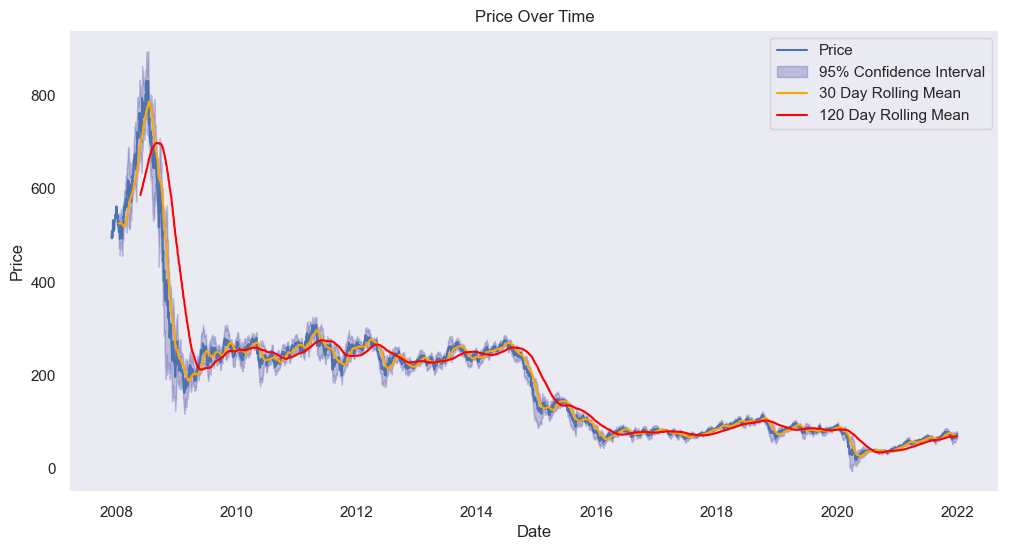

In [4]:
# let's also plot the price
plt.figure(figsize=(12, 6))
plt.plot(raw_data['Date'], raw_data['Price'], label='Price')
# plot 95% confidence interval
plt.fill_between(raw_data['Date'], raw_data['Price'] - 1.96 * raw_data['Price'].rolling(30).std(),
                 raw_data['Price'] + 1.96 * raw_data['Price'].rolling(30).std(), color='navy', alpha=0.2,
                 label='95% Confidence Interval')

# plot rolling mean 30 days and 120 days
plt.plot(raw_data['Date'], raw_data['Price'].rolling(30).mean(), label='30 Day Rolling Mean', color='orange')
plt.plot(raw_data['Date'], raw_data['Price'].rolling(120).mean(), label='120 Day Rolling Mean', color='red')

plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


# 2
## Setting the Scene

Let's setup our error function, split our data how we will want to train and test.
Update: I called the function "MAPE_squared" despite being SMAPE, but this is just for the code.

Training is from January 2, 2008 to August 4, 2017.
Test is remaining.

We split cross valdiation from Jan 2 to Aug 4 into 5 folds.

In [5]:
# loss function we care about
# NOTE: named incorrectly lol, this is actually MSPE
def MAPE_squared(y_true, y_pred):
    # add small noise to y_true to avoid division by zero
    y_true = y_true + 1e-10
    return np.mean(np.abs((y_true - y_pred) / y_true) ** 2)

def MAPE(y_true, y_pred):
    # add small noise to y_true to avoid division by zero
    y_true = y_true + 1e-10
    return np.mean(np.abs((y_true - y_pred) / y_true))

# def SMAPE_squared(y_true, y_pred):
#     # add small noise to y_true and y_pred to avoid division by zero
#     y_true = y_true + 1e-10
#     y_pred = y_pred + 1e-10
#     return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) ** 2)

# split up the data for cross validation
# this will be done via a function, since we will need to do this multiple times
# and it will be different for each model

def kfold_split(X, y, k=5):
    # this will return k folds of the data split for time series
    # so, in total, the data will be split into k + 1 parts
    # the first fold will consist of the first 1/(k+1) of the data as train, and the next 1/(k+1) as test
    # the second fold will consist of the first 2/(k+1) of the data as train, and the next 1/(k+1) as test
    # and so on
    splits = {
        'train_X': [],
        'train_y': [],
        'val_X': [],
        'val_y': []
    }

    for i in range(k):
        # train data will be the first i/(k+1) of the data
        # val data will be the next 1/(k+1) of the data
        train_X = X[:int((i + 1) / (k + 1) * len(X))]
        train_y = y[:int((i + 1) / (k + 1) * len(y))]
        val_X = X[int((i + 1) / (k + 1) * len(X)):int((i + 2) / (k + 1) * len(X))]
        val_y = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]

        splits['train_X'].append(train_X)
        splits['train_y'].append(train_y)
        splits['val_X'].append(val_X)
        splits['val_y'].append(val_y)
    return splits

# 3
## Supervised Classical Machine Learning with Regularization
### (Boosting via XGBoost)

So, since we are not yet in the time-series world, we want need to capture essence of the nature of data via feature engineering.

In [6]:
df = raw_data.copy()

# we start with Jan 2, 2008
# training set ends at Aug 4, 2017
training_df = df[(df['Date'] <= '2017-08-04') & (df['Date'] >= '2008-01-02')]
test_df = df[df['Date'] > '2017-08-04']

# check for missing values
print("Missing values in training set:")
print(training_df.isnull().sum())
print("Missing values in test set:")
print(test_df.isnull().sum())

def preprocess_xgboost(df, lags = [1, 2, 3, 4, 5, 15]):
    df = df.copy()
    # split date into year, month, day of week
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    # check for holidays
    df['IsHoliday'] =df['Date'].isin(us_holidays)
    if not df['IsHoliday'].any():
        # print("No holidays in the data")
        df = df.drop(columns=['IsHoliday'])

    # check for weekends
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])
    if not df['IsWeekend'].any():
        # print("No weekends in the data")
        df = df.drop(columns=['IsWeekend'])

    # add cyclical features

    # this helps the model tell which month it is
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # then this tells where it is in the half of the year
    df['Month_sin_6'] = np.sin(2 * np.pi * df['Month'] / 6)
    df['Month_cos_6'] = np.cos(2 * np.pi * df['Month'] / 6)

    # then this tells where it is in the quarter of the year
    df['Month_sin_4'] = np.sin(2 * np.pi * df['Month'] / 4)
    df['Month_cos_4'] = np.cos(2 * np.pi * df['Month'] / 4)

    # day of week: add cyclic features for every 7 days
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_sin_3'] = np.sin(2 * np.pi * df['DayOfWeek'] / 3)
    df['DayOfWeek_cos_3'] = np.cos(2 * np.pi * df['DayOfWeek'] / 3)
    df['DayOfWeek_sin_2'] = np.sin(2 * np.pi * df['DayOfWeek'] / 2)
    df['DayOfWeek_cos_2'] = np.cos(2 * np.pi * df['DayOfWeek'] / 2)

    # add cyclic features for the year based on the year
    # for now, assume a 3 year cycle and a 2 year cycle
    df['Year_sin_3'] = np.sin(2 * np.pi * (df['Year'] % 3)/3)
    df['Year_cos_3'] = np.cos(2 * np.pi * (df['Year'] % 3)/3)
    df['Year_sin_2'] = np.sin(2 * np.pi * (df['Year'] % 2)/2)
    df['Year_cos_2'] = np.cos(2 * np.pi * (df['Year'] % 2)/2)

    # drop the original features
    df = df.drop(columns=['Year', 'Month', 'DayOfWeek'])

    # add lag features
    # lag for 1,2,3,4,5,15 days
    for lag in lags:
        df['Lag_' + str(lag)] = df['Price'].shift(lag)

    # due to lag, we need to drop rows with NaN values
    df = df.dropna()

    return df

training_df_processed = preprocess_xgboost(training_df)
test_df_processed = preprocess_xgboost(test_df)


Missing values in training set:
Date                0
Price               0
LogPercentChange    0
dtype: int64
Missing values in test set:
Date                0
Price               0
LogPercentChange    0
dtype: int64


# 3.1
## Fitting the Model

In [8]:
horizons = [1,5,10,20]

In [10]:
def predict_date_forecast(df, model, date, horizon, lags = [1, 2, 3, 4, 5, 15]):
    '''
    Predicts the price for a given date, but the model can only see the data up to
    the date minus the horizon.
    '''
    df = df.copy()
    df = preprocess_xgboost(df, lags=[])

    # convert date to datetime
    date = pd.to_datetime(date)
    # check if date is in the data
    if date not in df['Date'].values:
        # if not, return None
        return None
    
    for lag in lags:
        # make blank lag features
        df['Lag_' + str(lag)] = np.nan
    
    # get the index of the date
    date_index = df[df['Date'] == date].index[0]

    # we have to start from the date - horizon
    curr_index = date_index - horizon

    while curr_index < date_index:
        # fill in the lags using previous values
        for lag in lags:
            if curr_index - lag >= 0:
                df.at[curr_index, 'Lag_' + str(lag)] = df.at[curr_index - lag, 'Price']
            else:
                df.at[curr_index, 'Lag_' + str(lag)] = np.nan

        to_input = df.iloc[[curr_index]].drop(['LogPercentChange', 'Date', 'Price'], axis=1)

        # predict tomorrows value
        tomorrows_value = model.predict(to_input)
        # fill in the price
        df.at[curr_index, 'Price'] = tomorrows_value


        curr_index += 1

    # return the price for the date
    return model.predict(to_input)[0]

In [8]:
kfolds = kfold_split(X_train, y_train, k=5)

NameError: name 'X_train' is not defined

In [ ]:
import numpy as np
from sklearn.model_selection import BaseCrossValidator, GridSearchCV
from xgboost import XGBRegressor
import tqdm

param_grid = {
    'n_estimators':     [500, 1000, 1250, 1500, 2000, 2500],
    'learning_rate':    [0.01, 0.05, 0.1],
    'max_depth':        [3, 5, 7],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.1, 1],
    'reg_lambda':       [1, 5, 10],
}


model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
)

# number of iterations to run
iters = 50

np.random.seed(195)

# create a list to store the results

for horizon in horizons:
    print("Horizon: ", horizon)
    results = []
    if horizon == 1:
        X_train, y_train = training_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), training_df_processed['Price']
        X_test, y_test = test_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), test_df_processed['Price']
    else:
        X_train, y_train = training_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), training_df_processed['Price']
        X_test, y_test = test_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), test_df_processed['Price']

        X_train = X_train.iloc[:-horizon + 1]
        y_train = y_train.iloc[horizon - 1:]
        X_test = X_test.iloc[:-horizon + 1]
        y_test = y_test.iloc[horizon - 1:]

    kfolds = kfold_split(X_train, y_train, k=5)

    for _ in tqdm.tqdm(range(iters)):
        # get a random sample of params
        params = {k: np.random.choice(v) for k, v in param_grid.items()}

        model = XGBRegressor(
            objective='reg:squarederror', # i tried implementing training via MAPE but ran into kernel errors
            eval_metric='mape',
            tree_method='hist',
            random_state=195,
            **params
        )

        cv_results = []

        # fit on each fold and evaluate
        for i in range(len(kfolds['train_X'])):
            train_X = kfolds['train_X'][i]
            train_y = kfolds['train_y'][i]
            val_X = kfolds['val_X'][i]
            val_y = kfolds['val_y'][i]

            model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)

            # predict out from horizon
            y_pred = model.predict(val_X)

            # calculate MAPE
            mape = MAPE_squared(val_y, y_pred)
            cv_results.append(mape)

        # calculate the mean and std of the MAPE
        mean_mape = np.mean(cv_results)
        std_mape = np.std(cv_results)
        # append the results
        results.append({
            'params': params,
            'mean_mape': mean_mape,
            'std_mape': std_mape
        })
    # sort the results by mean_mape
    results = sorted(results, key=lambda x: x['mean_mape'])

    # find the lowest mean_mape
    best_result = results[0]
    print("Best result:")
    print("Params: ", best_result['params'])
    # write result to txt file
    with open('best_result_xgboost.txt', 'a+') as f:
        f.write("--" * 20 + "\n")
        f.write("Best result for horizon " + str(horizon) + "\n")
        f.write("Params: " + str(best_result['params']) + "\n")
        f.write("Mean MAPE: " + str(best_result['mean_mape']) + "\n")
        f.write("Std MAPE: " + str(best_result['std_mape']) + "\n")
        f.write("--" * 20 + "\n")
        f.write("\n")
    print("Mean MAPE: ", best_result['mean_mape'])
    print("Std MAPE: ", best_result['std_mape'])



/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_98104/3281368896.py:35: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_y = y[:int((i + 1) / (k + 1) * len(y))]
/var/folders/9s/qn1jdn4d61xfh1lt2w3rlvrm0000gn/T/ipykernel_98104/3281368896.py:37: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  val_y = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]


Horizon:  1


  0%|          | 0/50 [00:03<?, ?it/s]


KeyboardInterrupt: 

Of course, this isn't too useful. Predicting the previous day's price will almost always be the best option. Instead, we want to test forecasting capabilities.

To do this, we have to create a function that recursively feeds information back into the model.

## Results

These are the results

Best result for horizon 1
Params: {'n_estimators': 2500, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 10}
Mean MAPE: 0.05743338447412959
Std MAPE: 0.10494225449284893



Best result for horizon 5
Params: {'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 1}
Mean MAPE: 0.1013529567152475
Std MAPE: 0.16414967217138435



Best result for horizon 10
Params: {'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 10}
Mean MAPE: 0.13986187553620436
Std MAPE: 0.21017620328315526



Best result for horizon 20
Params: {'n_estimators': 1250, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 1}
Mean MAPE: 0.22124849858574347
Std MAPE: 0.29612938658304794




# 4)
## ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

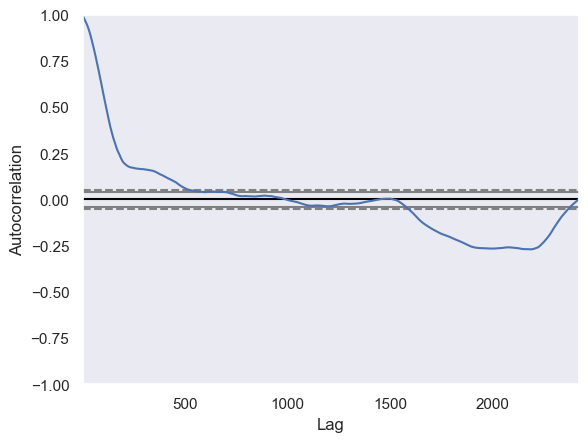

In [11]:
# train ARIMA model with different params
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

# we start with Jan 2, 2008
# training set ends at Aug 4, 2017
training_df = df[(df['Date'] <= '2017-08-04') & (df['Date'] >= '2008-01-02')]
test_df = df[df['Date'] > '2017-08-04']
full_df = pd.concat([training_df, test_df], axis=0)


# this autocorrelation plot seems to show a VERY LONG lag for covariance stationarity
# sadly, a lag of 500 doesn't seem reasonable, so we will cv on the ARIMA params
autocorrelation_plot(training_df['Price'])

In [26]:
from copy import deepcopy
import tqdm


def forecast_test(model, training_df, test_df, steps=1, progress_bar = True):
    model = deepcopy(model)
    # reset model history to steps - 1
    if steps == 1:
        history = training_df['Price']
    else:
        history = training_df['Price'].iloc[:(-steps + 1)]
    model = model.apply(history, refit=False)
    # training prices to include
    if steps == 1:
        training_prices_for_test = []
    else:
        training_prices_for_test = training_df['Price'].iloc[(-steps + 1):].values

    if steps == 1:
        test_prices_to_include = test_df['Price'].values
    else:
        test_prices_to_include = test_df['Price'].iloc[:(-steps + 1)].values

    all_prices = np.concatenate([training_prices_for_test, test_prices_to_include])

    predictions = []
    if progress_bar:
        all_prices_iter = tqdm.tqdm(all_prices)
    else:
        all_prices_iter = all_prices
    for actual in all_prices_iter:
        # 3a. forecast t+1
        yhat = model.forecast(steps=steps).iloc[-1]
        predictions.append(yhat)
        
        # 3b. update the state with the true observation
        #     refit=False means params stay fixed
        model = model.append(endog=[actual], refit=False)

    return np.array(predictions)

def ARIMA_cv_fold_split(y, k=5, order=(1, 1, 1), horizon=1):
    # this will return k folds of the data split for time series
    # so, in total, the data will be split into k + 1 parts
    # the first fold will consist of the first 1/(k+1) of the data as train, and the next 1/(k+1) as test
    # the second fold will consist of the first 2/(k+1) of the data as train, and the next 1/(k+1) as test
    # and so on
    splits = {
        'train': [],
        'val': []
    }

    for i in range(k):
        # train data will be the first i/(k+1) of the data
        # val data will be the next 1/(k+1) of the data
        train = y[:int((i + 1) / (k + 1) * len(y))]
        val = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]

        splits['train'].append(train)
        splits['val'].append(val)

    cv_MAPE = []

    for i in range(k):
        train = splits['train'][i]
        val = splits['val'][i]

        model = ARIMA(train, order=order)
        model_fit = model.fit()

        train_with_price = pd.DataFrame(train, columns=['Price'])
        val_with_price = pd.DataFrame(val, columns=['Price'])

        y_pred = forecast_test(model_fit, training_df=train_with_price, test_df=val_with_price, steps=horizon, progress_bar=False)

        # calculate MAPE
        mape = MAPE_squared(val, y_pred)
        cv_MAPE.append(mape)

        # plt.plot(val.index, val, label='True')
        # plt.plot(val.index, y_pred, label='Predicted')
        # plt.title('True vs Predicted')
        # plt.xlabel('Date')
        # plt.ylabel('Price')
        # plt.legend()
        # plt.grid()
        # plt.show()

    return cv_MAPE

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

pdq_param_grid = [
    (1, 1, 1),
    (3, 3, 3),
    (5, 1, 0),
    (5, 5, 5),
    (10, 1, 0),
    (10, 1, 5),
    (10, 2, 5),
    (10, 3, 5),
    (20, 1, 5),
    (30, 1, 0),
    (30, 1, 5),
    (30, 3, 5)
]

for horizon in horizons:
    best_params = None
    best_mape = float('inf')

    for params in tqdm.tqdm(pdq_param_grid):
        try:
            cv_MAPE = ARIMA_cv_fold_split(training_df['Price'], k=5, order=params, horizon=horizon)
            mean_mape = np.mean(cv_MAPE)
            if mean_mape < best_mape:
                best_mape = mean_mape
                best_params = params
        except Exception as e:
            print(f"Error with params {params}: {e}")
            continue
    print(f"Best params for horizon {horizon}: {best_params} with MAPE {best_mape}")
    # write result to txt file
    with open('best_result_arima.txt', 'a+') as f:
        f.write("--" * 20 + "\n")
        f.write("Best result for horizon " + str(horizon) + "\n")
        f.write("Params: " + str(best_params) + "\n")
        f.write("Mean MAPE: " + str(mean_mape) + "\n")
        f.write("--" * 20 + "\n")
        f.write("\n")

  0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Results


Best result for horizon 1
Params: (1, 1, 1)
Mean MAPE: 0.00044999784040707883



Best result for horizon 5
Params: (1, 1, 1)
Mean MAPE: 0.002256195961838884



Best result for horizon 10
Params: (1, 1, 1)
Mean MAPE: 0.005236947227544556



Best result for horizon 20
Params: (10, 1, 0)
Mean MAPE: 0.013599505614634282




# 5
## RNN

Ok, this is the main part of the project (that I've been dreading, because something always goes wrong when training neural networks)

Like XGBoost, we will have 4 models for training, each cross validated for best parameters with each horizon.

Things will be a little difficult here, just because there are A LOT of parameters, like layers, regularization, etc.

### NOTE:

This cell takes A WHILE to run. After some time and a lot of testing around, I got these results:

horizon_1_look_back = 15
horizon_5_look_back = 10
horizon_10_look_back = 15
horizon_20_look_back = 25

nn_1_horizon = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

nn_5_horizon = Sequential([
    LSTM(40, activation='relu', input_shape=(look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)
])

nn_10_horizon = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

nn_20_horizon = Sequential([
    LSTM(80, activation='relu', input_shape=(look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

In [13]:
def create_sequences(data, look_back=1):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 30 day look back
look_back = 30

LSTM_param_grid = [
    Sequential([
        LSTM(100, activation='relu', input_shape=(30, 1)),
        Dense(1)
    ]),
    Sequential([
        LSTM(50, activation='relu', input_shape=(30, 1), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ]),
    Sequential([
        LSTM(100, activation='relu', input_shape=(30, 1), return_sequences=True),
        LSTM(100, activation='relu'),
        Dense(1)
    ]),
    Sequential([
        LSTM(100, activation='relu', input_shape=(30, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(1)
    ]),
    Sequential([
        LSTM(100, activation='relu', input_shape=(30, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01), return_sequences=True),
        LSTM(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dense(1)
    ]),
]

# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def NN_cv_fold_split(y, model_structure, k=5, horizon = 1):
    # this will return k folds of the data split for time series
    # so, in total, the data will be split into k + 1 parts
    # the first fold will consist of the first 1/(k+1) of the data as train, and the next 1/(k+1) as test
    # the second fold will consist of the first 2/(k+1) of the data as train, and the next 1/(k+1) as test
    # and so on
    splits = {
        'X_train': [],
        'y_train': [],
        'X_val': [],
        'y_val': []
    }

    for i in range(k):
        # train data will be the first i/(k+1) of the data
        # val data will be the next 1/(k+1) of the data
        train = y[:int((i + 1) / (k + 1) * len(y))]
        val = y[int((i + 1) / (k + 1) * len(y)):int((i + 2) / (k + 1) * len(y))]

        X_train, y_train = create_sequences(train, look_back)
        X_val, y_val = create_sequences(val, look_back)

        if horizon > 1:
            X_train = X_train[:-horizon + 1]
            y_train = y_train[horizon - 1:]
            X_val = X_val[:-horizon + 1]
            y_val = y_val[horizon - 1:]

        splits['X_train'].append(X_train)
        splits['y_train'].append(y_train)
        splits['X_val'].append(X_val)
        splits['y_val'].append(y_val)
            

    cv_MAPE = []

    for i in range(k):
        X_train = splits['X_train'][i]
        y_train = splits['y_train'][i]
        X_val = splits['X_val'][i]
        y_val = splits['y_val'][i]

        model = deepcopy(model_structure)
        model.compile(optimizer='adam', loss='mape')

        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
        y_pred = model.predict(X_val, verbose=0)

        print('Fit model on fold', i + 1)

        # calculate MAPE
        mape = MAPE_squared(val, y_pred)
        cv_MAPE.append(mape)

        # plt.plot(val.index, val, label='True')
        # plt.plot(val.index, y_pred, label='Predicted')
        # plt.title('True vs Predicted')
        # plt.xlabel('Date')
        # plt.ylabel('Price')
        # plt.legend()
        # plt.grid()
        # plt.show()

    return cv_MAPE


for horizon in horizons:
    best_mape = float('inf')
    best_model_index = None
    for i, model_structure in tqdm.tqdm(enumerate(LSTM_param_grid)):
        # print out the layers of the model
        cv_MAPE = NN_cv_fold_split(training_df['Price'].values, model_structure, k=5, horizon=horizon)
        mean_mape = np.mean(cv_MAPE)
        if mean_mape < best_mape:
            best_mape = mean_mape
            best_model_index = i
    print(f"Best params for horizon {horizon}: {best_model_index} with MAPE {best_mape}")
    # write result to txt file
    with open('best_result_lstm.txt', 'a+') as f:
        f.write("--" * 20 + "\n")
        f.write("Best result for horizon " + str(horizon) + "\n")
        f.write("Params: " + str(best_model_index) + "\n")
        f.write("Mean MAPE: " + str(mean_mape) + "\n")
        f.write("--" * 20 + "\n")
        f.write("\n")

KeyboardInterrupt: 

# 6
## Analysis

In [88]:
model_outputs = []
model_outputs_crisis = []

### XGBoost

In [89]:
from xgboost import XGBRegressor
# import mean_squared_error
from sklearn.metrics import mean_squared_error

horizon_1_params = {'n_estimators': 2500, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 10}
horizon_5_params = {'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 1}
horizon_10_params = {'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 10}
horizon_20_params = {'n_estimators': 1250, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 1}


# load all the models
horizon_1_xgboost = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
    **horizon_1_params
)
horizon_5_xgboost = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
    **horizon_5_params
)
horizon_10_xgboost = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
    **horizon_10_params
)
horizon_20_xgboost = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mape',
    tree_method='hist',
    random_state=42,
    **horizon_20_params
)

full_df_processed = preprocess_xgboost(full_df)


# get the training and test data
X_train, y_train = training_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), training_df_processed['Price']
X_test, y_test = test_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), test_df_processed['Price']

X_train_5_horizon = X_train.copy()
X_train_5_horizon = X_train_5_horizon.iloc[:-4]
y_train_5_horizon = y_train.copy()
y_train_5_horizon = y_train_5_horizon.iloc[4:]

X_test_5_horizon = X_test.copy()
X_test_5_horizon = X_test_5_horizon.iloc[:-4]
y_test_5_horizon = y_test.copy()
y_test_5_horizon = y_test_5_horizon.iloc[4:]

X_train_10_horizon = X_train.copy()
X_train_10_horizon = X_train_10_horizon.iloc[:-9]
y_train_10_horizon = y_train.copy()
y_train_10_horizon = y_train_10_horizon.iloc[9:]

X_test_10_horizon = X_test.copy()
X_test_10_horizon = X_test_10_horizon.iloc[:-9]
y_test_10_horizon = y_test.copy()
y_test_10_horizon = y_test_10_horizon.iloc[9:]

X_train_20_horizon = X_train.copy()
X_train_20_horizon = X_train_20_horizon.iloc[:-19]
y_train_20_horizon = y_train.copy()
y_train_20_horizon = y_train_20_horizon.iloc[19:]

X_test_20_horizon = X_test.copy()
X_test_20_horizon = X_test_20_horizon.iloc[:-19]
y_test_20_horizon = y_test.copy()
y_test_20_horizon = y_test_20_horizon.iloc[19:]

# fit the models
horizon_1_xgboost.fit(X_train, y_train)
horizon_5_xgboost.fit(X_train_5_horizon, y_train_5_horizon)
horizon_10_xgboost.fit(X_train_10_horizon, y_train_10_horizon)
horizon_20_xgboost.fit(X_train_20_horizon, y_train_20_horizon)

# report MAPE on test set
horizon_1_xgboost_pred = horizon_1_xgboost.predict(X_test)
horizon_5_xgboost_pred = horizon_5_xgboost.predict(X_test_5_horizon)
horizon_10_xgboost_pred = horizon_10_xgboost.predict(X_test_10_horizon)
horizon_20_xgboost_pred = horizon_20_xgboost.predict(X_test_20_horizon)

model_outputs.append({"model": "XGBoost", "horizon": 1, "mape^2": MAPE_squared(y_test, horizon_1_xgboost_pred), "mape": MAPE(y_test, horizon_1_xgboost_pred), "MSE" : mean_squared_error(y_test, horizon_1_xgboost_pred)})
model_outputs.append({"model": "XGBoost", "horizon": 5, "mape^2": MAPE_squared(y_test_5_horizon, horizon_5_xgboost_pred), "mape": MAPE(y_test_5_horizon, horizon_5_xgboost_pred), "MSE" : mean_squared_error(y_test_5_horizon, horizon_5_xgboost_pred)})
model_outputs.append({"model": "XGBoost", "horizon": 10, "mape^2": MAPE_squared(y_test_10_horizon, horizon_10_xgboost_pred), "mape": MAPE(y_test_10_horizon, horizon_10_xgboost_pred), "MSE": mean_squared_error(y_test_10_horizon, horizon_10_xgboost_pred)})
model_outputs.append({"model": "XGBoost", "horizon": 20, "mape^2": MAPE_squared(y_test_20_horizon, horizon_20_xgboost_pred), "mape": MAPE(y_test_20_horizon, horizon_20_xgboost_pred), "MSE" : mean_squared_error(y_test_20_horizon, horizon_20_xgboost_pred)})


# get results for crisis period
test_df_processed_copy = test_df_processed.copy()
test_df_processed_copy = test_df_processed_copy.reset_index(drop=True)
jan_2020_index = test_df_processed_copy[test_df_processed_copy['Date'] == '2020-01-02'].index[0]

model_outputs_crisis.append(
    {"model": "XGBoost", "horizon": 1, "mape^2": MAPE_squared(test_df_processed['Price'].iloc[jan_2020_index:], horizon_1_xgboost.predict(X_test.iloc[jan_2020_index:])), "mape": MAPE(test_df_processed['Price'].iloc[jan_2020_index:], horizon_1_xgboost.predict(X_test.iloc[jan_2020_index:])), "MSE": mean_squared_error(test_df_processed['Price'].iloc[jan_2020_index:], horizon_1_xgboost.predict(X_test.iloc[jan_2020_index:]))}
)
model_outputs_crisis.append(
    {"model": "XGBoost", "horizon": 5, "mape^2": MAPE_squared(test_df_processed['Price'].iloc[jan_2020_index + 4:], horizon_5_xgboost.predict(X_test_5_horizon.iloc[jan_2020_index:])), "mape": MAPE(test_df_processed['Price'].iloc[jan_2020_index + 4:], horizon_5_xgboost.predict(X_test_5_horizon.iloc[jan_2020_index:])), "MSE": mean_squared_error(test_df_processed['Price'].iloc[jan_2020_index + 4:], horizon_5_xgboost.predict(X_test_5_horizon.iloc[jan_2020_index:]))}
)
model_outputs_crisis.append(
    {"model": "XGBoost", "horizon": 10, "mape^2": MAPE_squared(test_df_processed['Price'].iloc[jan_2020_index + 9:], horizon_10_xgboost.predict(X_test_10_horizon.iloc[jan_2020_index:])), "mape": MAPE(test_df_processed['Price'].iloc[jan_2020_index + 9:], horizon_10_xgboost.predict(X_test_10_horizon.iloc[jan_2020_index:])), "MSE": mean_squared_error(test_df_processed['Price'].iloc[jan_2020_index + 9:], horizon_10_xgboost.predict(X_test_10_horizon.iloc[jan_2020_index:]))}
)
model_outputs_crisis.append(
    {"model": "XGBoost", "horizon": 20, "mape^2": MAPE_squared(test_df_processed['Price'].iloc[jan_2020_index + 19:], horizon_20_xgboost.predict(X_test_20_horizon.iloc[jan_2020_index:])), "mape": MAPE(test_df_processed['Price'].iloc[jan_2020_index + 19:], horizon_20_xgboost.predict(X_test_20_horizon.iloc[jan_2020_index:])), "MSE": mean_squared_error(test_df_processed['Price'].iloc[jan_2020_index + 19:], horizon_20_xgboost.predict(X_test_20_horizon.iloc[jan_2020_index:]))}
)

0.2020363482465257


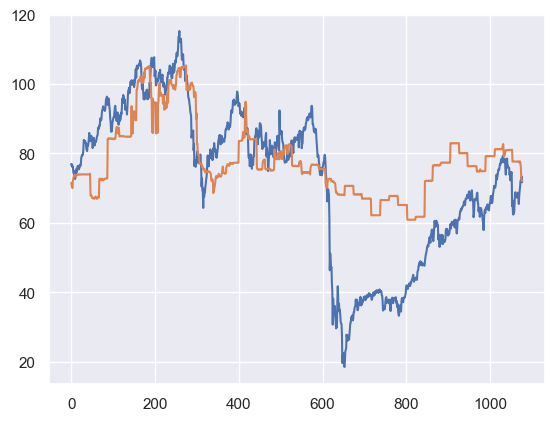

In [90]:
plt.plot(range(0, len(y_test_20_horizon)), y_test_20_horizon)
plt.plot(horizon_20_xgboost_pred)

print(MAPE_squared(y_test_20_horizon, horizon_20_xgboost_pred))

### ARIMA

In [91]:
ARIMA_1_horizon = ARIMA(training_df['Price'], order=(1, 1, 1)).fit()
ARIMA_5_horizon = ARIMA(training_df['Price'], order=(1, 1, 1)).fit()
ARIMA_10_horizon = ARIMA(training_df['Price'], order=(1, 1, 1)).fit()
ARIMA_20_horizon = ARIMA(training_df['Price'], order=(10, 1, 0)).fit()

ARIMA_1_horizon_pred = forecast_test(ARIMA_1_horizon, training_df, test_df, steps=1)
ARIMA_5_horizon_pred = forecast_test(ARIMA_5_horizon, training_df, test_df, steps=5)
ARIMA_10_horizon_pred = forecast_test(ARIMA_10_horizon, training_df, test_df, steps=10)
ARIMA_20_horizon_pred = forecast_test(ARIMA_20_horizon, training_df, test_df, steps=20)


model_outputs.append({"model": "ARIMA", "horizon": 1, "mape^2": MAPE_squared(test_df['Price'], ARIMA_1_horizon_pred), "mape": MAPE(test_df['Price'], ARIMA_1_horizon_pred), "MSE": mean_squared_error(test_df['Price'], ARIMA_1_horizon_pred)})
model_outputs.append({"model": "ARIMA", "horizon": 5, "mape^2": MAPE_squared(test_df['Price'], ARIMA_5_horizon_pred), "mape": MAPE(test_df['Price'], ARIMA_5_horizon_pred), "MSE": mean_squared_error(test_df['Price'], ARIMA_5_horizon_pred)})
model_outputs.append({"model": "ARIMA", "horizon": 10, "mape^2": MAPE_squared(test_df['Price'], ARIMA_10_horizon_pred), "mape": MAPE(test_df['Price'], ARIMA_10_horizon_pred), "MSE": mean_squared_error(test_df['Price'], ARIMA_10_horizon_pred)})
model_outputs.append({"model": "ARIMA", "horizon": 20, "mape^2": MAPE_squared(test_df['Price'], ARIMA_20_horizon_pred), "mape": MAPE(test_df['Price'], ARIMA_20_horizon_pred), "MSE": mean_squared_error(test_df['Price'], ARIMA_20_horizon_pred)})

test_df_copy = test_df.copy()
test_df_copy = test_df_copy.reset_index(drop=True)
jan_2020_index = test_df_copy[test_df_copy['Date'] == '2020-01-02'].index[0]
model_outputs_crisis.append(
    {"model": "ARIMA", "horizon": 1, "mape^2": MAPE_squared(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_1_horizon_pred[jan_2020_index:]), "mape": MAPE(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_1_horizon_pred[jan_2020_index:]), "MSE": mean_squared_error(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_1_horizon_pred[jan_2020_index:])}
)
model_outputs_crisis.append(
    {"model": "ARIMA", "horizon": 5, "mape^2": MAPE_squared(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_5_horizon_pred[jan_2020_index:]), "mape": MAPE(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_5_horizon_pred[jan_2020_index:]), "MSE": mean_squared_error(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_5_horizon_pred[jan_2020_index:])}
)
model_outputs_crisis.append(
    {"model": "ARIMA", "horizon": 10, "mape^2": MAPE_squared(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_10_horizon_pred[jan_2020_index:]), "mape": MAPE(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_10_horizon_pred[jan_2020_index:]), "MSE": mean_squared_error(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_10_horizon_pred[jan_2020_index:])}
)
model_outputs_crisis.append(
    {"model": "ARIMA", "horizon": 20, "mape^2": MAPE_squared(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_20_horizon_pred[jan_2020_index:]), "mape": MAPE(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_20_horizon_pred[jan_2020_index:]), "MSE": mean_squared_error(test_df_copy['Price'].iloc[jan_2020_index:], ARIMA_20_horizon_pred[jan_2020_index:])}
)

/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

### LSTM

In [92]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

# set tensorflow seed to 42
tf.random.set_seed(42)
# set random seed to 42
np.random.seed(42)

horizon_1_look_back = 10
horizon_5_look_back = 10
horizon_10_look_back = 12
horizon_20_look_back = 25

nn_1_horizon = Sequential([
    LSTM(64, activation='relu', input_shape=(horizon_1_look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

nn_5_horizon = Sequential([
    LSTM(64, activation='relu', input_shape=(horizon_5_look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dense(1)
])

nn_10_horizon = Sequential([
    LSTM(70, activation='relu', input_shape=(horizon_10_look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    Dense(1)
])

nn_20_horizon = Sequential([
    LSTM(80, activation='relu', input_shape=(horizon_20_look_back, 1), kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    Dense(1)
])

X_train_1_horizon, y_train_1_horizon = create_sequences(training_df['Price'].values, look_back=horizon_1_look_back)
X_test_1_horizon, y_test_1_horizon = create_sequences(test_df['Price'].values, look_back=horizon_1_look_back)

X_train_5_horizon, y_train_5_horizon = create_sequences(training_df['Price'].values, look_back=horizon_5_look_back)
X_test_5_horizon, y_test_5_horizon = create_sequences(test_df['Price'].values, look_back=horizon_5_look_back)

X_train_5_horizon = X_train_5_horizon.copy()
X_train_5_horizon = X_train_5_horizon[:-4]
y_train_5_horizon = y_train_5_horizon.copy()
y_train_5_horizon = y_train_5_horizon[4:]
X_test_5_horizon = X_test_5_horizon.copy()
X_test_5_horizon = X_test_5_horizon[:-4]
y_test_5_horizon = y_test_5_horizon.copy()
y_test_5_horizon = y_test_5_horizon[4:]

X_train_10_horizon, y_train_10_horizon = create_sequences(training_df['Price'].values, look_back=horizon_10_look_back)
X_test_10_horizon, y_test_10_horizon = create_sequences(test_df['Price'].values, look_back=horizon_10_look_back)

X_train_10_horizon = X_train_10_horizon.copy()
X_train_10_horizon = X_train_10_horizon[:-9]
y_train_10_horizon = y_train_10_horizon.copy()
y_train_10_horizon = y_train_10_horizon[9:]
X_test_10_horizon = X_test_10_horizon.copy()
X_test_10_horizon = X_test_10_horizon[:-9]
y_test_10_horizon = y_test_10_horizon.copy()
y_test_10_horizon = y_test_10_horizon[9:]

X_train_20_horizon, y_train_20_horizon = create_sequences(training_df['Price'].values, look_back=horizon_20_look_back)
X_test_20_horizon, y_test_20_horizon = create_sequences(test_df['Price'].values, look_back=horizon_20_look_back)

X_train_20_horizon = X_train_20_horizon.copy()
X_train_20_horizon = X_train_20_horizon[:-19]
y_train_20_horizon = y_train_20_horizon.copy()
y_train_20_horizon = y_train_20_horizon[19:]
X_test_20_horizon = X_test_20_horizon.copy()
X_test_20_horizon = X_test_20_horizon[:-19]
y_test_20_horizon = y_test_20_horizon.copy()
y_test_20_horizon = y_test_20_horizon[19:]

# compile the models
nn_1_horizon.compile(optimizer='adam', loss='mape')
nn_5_horizon.compile(optimizer='adam', loss='mape')
nn_10_horizon.compile(optimizer='adam', loss='mape')
nn_20_horizon.compile(optimizer='adam', loss='mape')

# fit the models
print("Fitting models...")
print("Fitting model 1...")
history_1_horizon = nn_1_horizon.fit(X_train_1_horizon, y_train_1_horizon, epochs=120, batch_size=64, validation_split=0.1, verbose=0)
print("Fitting model 5...")
history_5_horizon = nn_5_horizon.fit(X_train_5_horizon, y_train_5_horizon, epochs=80, batch_size=64, validation_split=0.1, verbose=0)
print("Fitting model 10...")
history_10_horizon = nn_10_horizon.fit(X_train_10_horizon, y_train_10_horizon, epochs=80, batch_size=64, validation_split=0.1, verbose=0)
print("Fitting model 20...")
history_20_horizon = nn_20_horizon.fit(X_train_20_horizon, y_train_20_horizon, epochs=120, batch_size=64, validation_split=0.1, verbose=0)

# report MAPE on test set
nn_1_horizon_pred = nn_1_horizon.predict(X_test_1_horizon)
nn_5_horizon_pred = nn_5_horizon.predict(X_test_5_horizon)
nn_10_horizon_pred = nn_10_horizon.predict(X_test_10_horizon)
nn_20_horizon_pred = nn_20_horizon.predict(X_test_20_horizon)

model_outputs.append({"model": "LSTM", "horizon": 1, "mape^2": MAPE_squared(y_test_1_horizon, nn_1_horizon_pred), "mape": MAPE(y_test_1_horizon, nn_1_horizon_pred), "MSE": mean_squared_error(y_test_1_horizon, nn_1_horizon_pred)})
model_outputs.append({"model": "LSTM", "horizon": 5, "mape^2": MAPE_squared(y_test_5_horizon, nn_5_horizon_pred), "mape": MAPE(y_test_5_horizon, nn_5_horizon_pred), "MSE": mean_squared_error(y_test_5_horizon, nn_5_horizon_pred)})
model_outputs.append({"model": "LSTM", "horizon": 10, "mape^2": MAPE_squared(y_test_10_horizon, nn_10_horizon_pred), "mape": MAPE(y_test_10_horizon, nn_10_horizon_pred), "MSE": mean_squared_error(y_test_10_horizon, nn_10_horizon_pred)})
model_outputs.append({"model": "LSTM", "horizon": 20, "mape^2": MAPE_squared(y_test_20_horizon, nn_20_horizon_pred), "mape": MAPE(y_test_20_horizon, nn_20_horizon_pred), "MSE": mean_squared_error(y_test_20_horizon, nn_20_horizon_pred)})

model_outputs_crisis.append(
    {"model": "LSTM", "horizon": 1, "mape^2": MAPE_squared(test_df['Price'].iloc[jan_2020_index + horizon_1_look_back:], nn_1_horizon.predict(X_test_1_horizon[jan_2020_index:]).reshape(-1)), "mape": MAPE(test_df['Price'].iloc[jan_2020_index + horizon_1_look_back:], nn_1_horizon.predict(X_test_1_horizon[jan_2020_index:]).reshape(-1)), "MSE" : mean_squared_error(test_df['Price'].iloc[jan_2020_index + horizon_1_look_back:], nn_1_horizon.predict(X_test_1_horizon[jan_2020_index:]).reshape(-1))}  # reshape to 1D array    
)

model_outputs_crisis.append(
    {"model": "LSTM", "horizon": 5, "mape^2": MAPE_squared(test_df['Price'].iloc[jan_2020_index + horizon_5_look_back + 4:], nn_5_horizon.predict(X_test_5_horizon[jan_2020_index:]).reshape(-1)), "mape": MAPE(test_df['Price'].iloc[jan_2020_index + horizon_5_look_back + 4:], nn_5_horizon.predict(X_test_5_horizon[jan_2020_index:]).reshape(-1)), "MSE" : mean_squared_error(test_df['Price'].iloc[jan_2020_index + horizon_5_look_back + 4:], nn_5_horizon.predict(X_test_5_horizon[jan_2020_index:]).reshape(-1))}  # reshape to 1D array
)
model_outputs_crisis.append(
    {"model": "LSTM", "horizon": 10, "mape^2": MAPE_squared(test_df['Price'].iloc[jan_2020_index + horizon_10_look_back + 9:], nn_10_horizon.predict(X_test_10_horizon[jan_2020_index:]).reshape(-1)), "mape": MAPE(test_df['Price'].iloc[jan_2020_index + horizon_10_look_back + 9:], nn_10_horizon.predict(X_test_10_horizon[jan_2020_index:]).reshape(-1)), "MSE" : mean_squared_error(test_df['Price'].iloc[jan_2020_index + horizon_10_look_back + 9:], nn_10_horizon.predict(X_test_10_horizon[jan_2020_index:]).reshape(-1))}  # reshape to 1D array    
)
model_outputs_crisis.append(
    {"model": "LSTM", "horizon": 20, "mape^2": MAPE_squared(test_df['Price'].iloc[jan_2020_index + horizon_20_look_back + 19:], nn_20_horizon.predict(X_test_20_horizon[jan_2020_index:]).reshape(-1)), "mape": MAPE(test_df['Price'].iloc[jan_2020_index + horizon_20_look_back + 19:], nn_20_horizon.predict(X_test_20_horizon[jan_2020_index:]).reshape(-1)), "MSE" : mean_squared_error(test_df['Price'].iloc[jan_2020_index + horizon_20_look_back + 19:], nn_20_horizon.predict(X_test_20_horizon[jan_2020_index:]).reshape(-1))}  # reshape to 1D array
)



/Users/nickydtricky/miniforge3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting models...
Fitting model 1...
Fitting model 5...
Fitting model 10...
Fitting model 20...
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


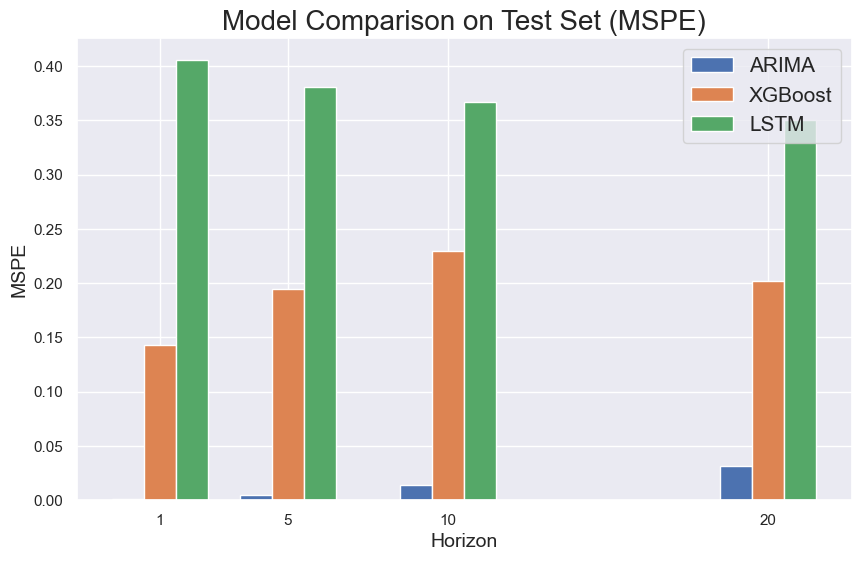

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_df = pd.DataFrame(model_outputs)
model_outputs_df['log_mape'] = abs(np.log(model_outputs_df['mape^2']))

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_df.pivot(index='horizon', columns='model', values='mape^2')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend(fontsize=15)
ax.set_title('Model Comparison on Test Set (MSPE)', fontsize=20)
plt.savefig('figs/model_comparison_full_test_mspe.png', dpi=500)
plt.show()


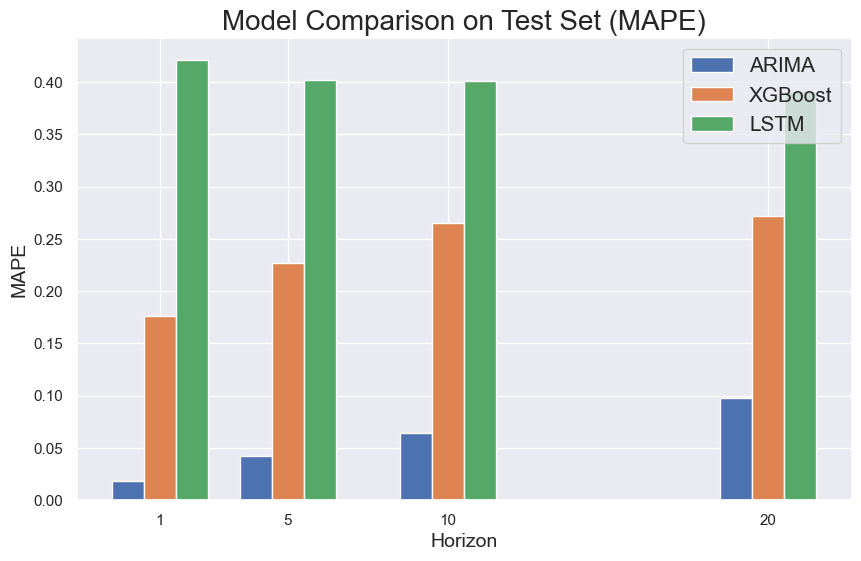

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_df = pd.DataFrame(model_outputs)
model_outputs_df['log_mape'] = abs(np.log(model_outputs_df['mape']))

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_df.pivot(index='horizon', columns='model', values='mape')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MAPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend(fontsize=15)
ax.set_title('Model Comparison on Test Set (MAPE)', fontsize=20)
plt.savefig('figs/model_comparison_full_test_mape.png', dpi=500)
plt.show()


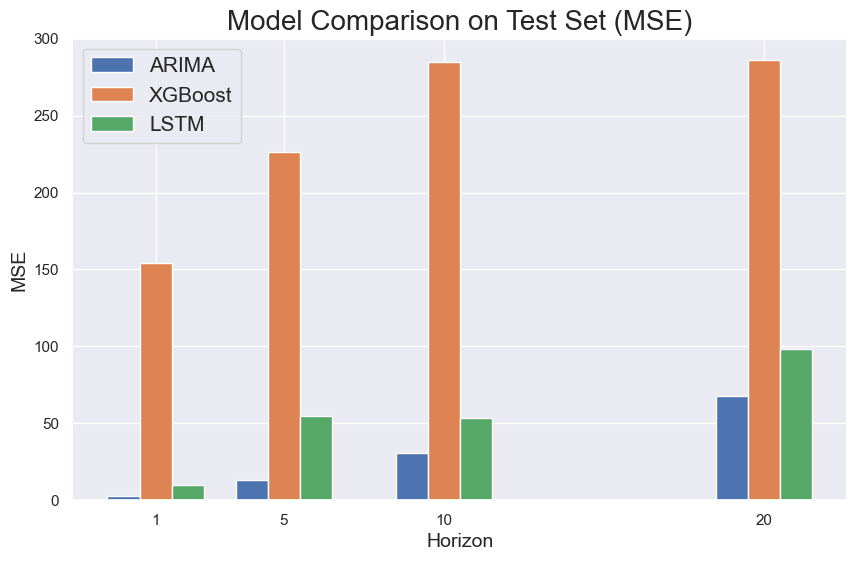

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_df = pd.DataFrame(model_outputs)
model_outputs_df['log_mape'] = abs(np.log(model_outputs_df['MSE']))

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_df.pivot(index='horizon', columns='model', values='MSE')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend(fontsize=15)
ax.set_title('Model Comparison on Test Set (MSE)', fontsize=20)
plt.savefig('figs/model_comparison_full_test_MSE.png', dpi=500)
plt.show()


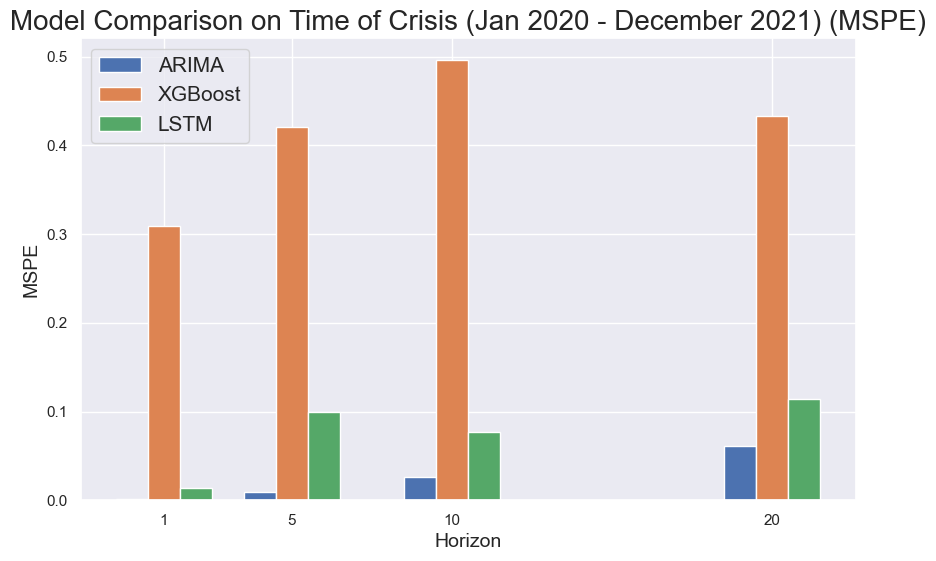

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_crisis_df = pd.DataFrame(model_outputs_crisis)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_crisis_df.pivot(index='horizon', columns='model', values='mape^2')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Time of Crisis (Jan 2020 - December 2021) (MSPE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_crisis_mspe.png', dpi=500)
plt.show()


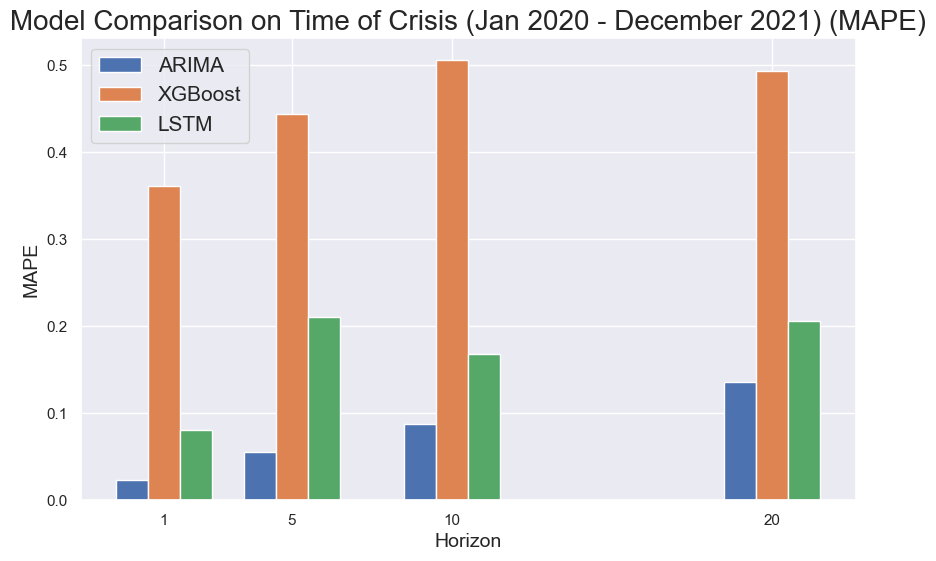

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_crisis_df = pd.DataFrame(model_outputs_crisis)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_crisis_df.pivot(index='horizon', columns='model', values='mape')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MAPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Time of Crisis (Jan 2020 - December 2021) (MAPE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_crisis_mape.png', dpi=500)
plt.show()


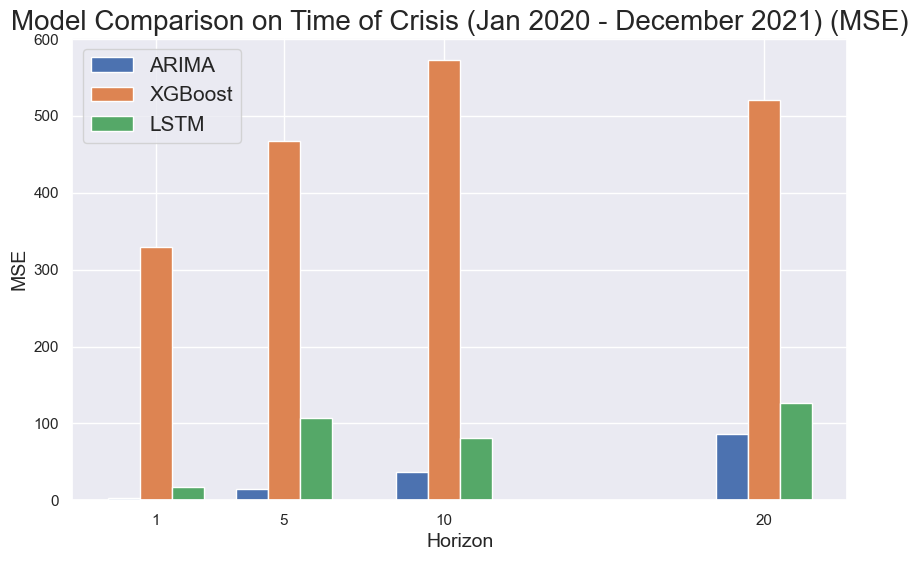

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_crisis_df = pd.DataFrame(model_outputs_crisis)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_crisis_df.pivot(index='horizon', columns='model', values='MSE')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Time of Crisis (Jan 2020 - December 2021) (MSE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_crisis_mse.png', dpi=500)
plt.show()


## Visuals for Prediction

In [99]:
# visuals for XGBoost
full_df_processed = preprocess_xgboost(full_df)

X_train, y_train = training_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), training_df_processed['Price']
X_test, y_test = test_df_processed.drop(columns=['LogPercentChange', 'Date', 'Price']), test_df_processed['Price']

X_train_5_horizon = X_train.copy()
X_train_5_horizon = X_train_5_horizon.iloc[:-4]
y_train_5_horizon = y_train.copy()
y_train_5_horizon = y_train_5_horizon.iloc[4:]

X_test_5_horizon = X_test.copy()
X_test_5_horizon = X_test_5_horizon.iloc[:-4]
y_test_5_horizon = y_test.copy()
y_test_5_horizon = y_test_5_horizon.iloc[4:]

X_train_10_horizon = X_train.copy()
X_train_10_horizon = X_train_10_horizon.iloc[:-9]
y_train_10_horizon = y_train.copy()
y_train_10_horizon = y_train_10_horizon.iloc[9:]

X_test_10_horizon = X_test.copy()
X_test_10_horizon = X_test_10_horizon.iloc[:-9]
y_test_10_horizon = y_test.copy()
y_test_10_horizon = y_test_10_horizon.iloc[9:]

X_train_20_horizon = X_train.copy()
X_train_20_horizon = X_train_20_horizon.iloc[:-19]
y_train_20_horizon = y_train.copy()
y_train_20_horizon = y_train_20_horizon.iloc[19:]

X_test_20_horizon = X_test.copy()
X_test_20_horizon = X_test_20_horizon.iloc[:-19]
y_test_20_horizon = y_test.copy()
y_test_20_horizon = y_test_20_horizon.iloc[19:]

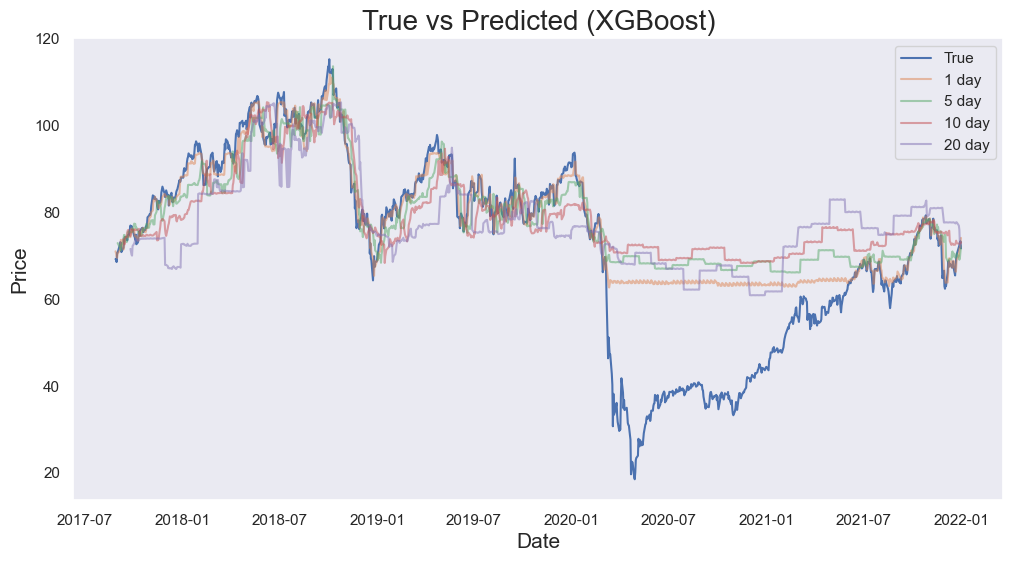

In [ ]:
# predict all XBoost values
plt.figure(figsize=(12, 6))
plt.plot(test_df_processed['Date'], y_test, label='True')
plt.plot(test_df_processed['Date'], horizon_1_xgboost.predict(X_test), label='1 day', alpha=0.5)
plt.plot(test_df_processed['Date'].iloc[4:], horizon_5_xgboost.predict(X_test_5_horizon), label='5 day', alpha=0.5)
plt.plot(test_df_processed['Date'].iloc[9:], horizon_10_xgboost.predict(X_test_10_horizon), label='10 day', alpha=0.5)
plt.plot(test_df_processed['Date'].iloc[19:], horizon_20_xgboost.predict(X_test_20_horizon), label='20 day', alpha=0.5)
plt.title('True vs Predicted (XGBoost)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('figs/xgboost_full_test.png', dpi=500)
plt.show()

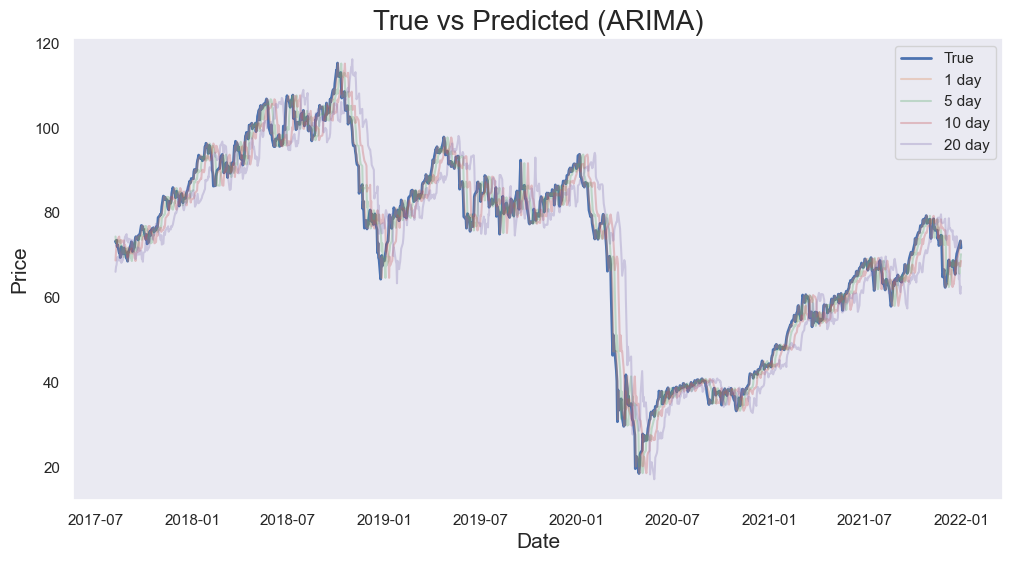

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Price'], label='True', linewidth=2)
plt.plot(test_df['Date'], ARIMA_1_horizon_pred, label='1 day', alpha=0.3)
plt.plot(test_df['Date'], ARIMA_5_horizon_pred, label='5 day', alpha=0.3)
plt.plot(test_df['Date'], ARIMA_10_horizon_pred, label='10 day', alpha=0.3)
plt.plot(test_df['Date'], ARIMA_20_horizon_pred, label='20 day', alpha=0.3)
plt.title('True vs Predicted (ARIMA)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('figs/arima_full_test.png', dpi=500)
plt.show()

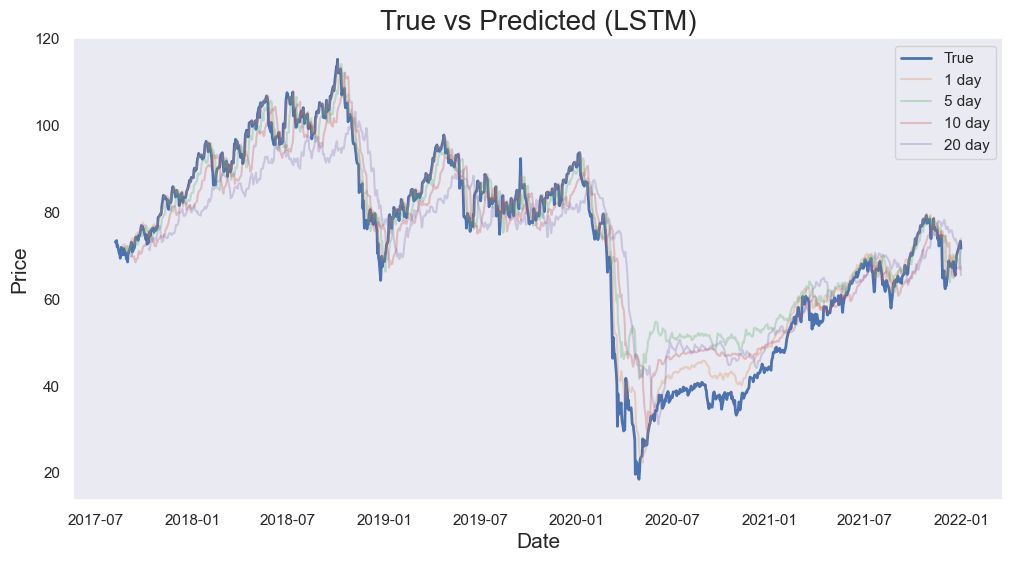

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], test_df['Price'], label='True', linewidth=2)
plt.plot(test_df['Date'].iloc[horizon_1_look_back:], nn_1_horizon_pred, label='1 day', alpha=0.3)
plt.plot(test_df['Date'].iloc[horizon_5_look_back + 4:], nn_5_horizon_pred, label='5 day', alpha=0.3)
plt.plot(test_df['Date'].iloc[horizon_10_look_back + 9:], nn_10_horizon_pred, label='10 day', alpha=0.3)
plt.plot(test_df['Date'].iloc[horizon_20_look_back + 19:], nn_20_horizon_pred, label='20 day', alpha=0.3)
plt.legend()
plt.grid()

# make the label and title texts larger
plt.title('True vs Predicted (LSTM)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.savefig('figs/lstm_full_test.png', dpi=500)
plt.show()

In [ ]:
model_outputs_df.to_csv('results/model_outputs.csv', index=False)
model_outputs_crisis_df.to_csv('results/model_outputs_crisis.csv', index=False)

In [110]:
jan_2020_index = test_df_processed_copy[test_df_processed_copy['Date'] == '2017-09-05'].index[0]
print(jan_2020_index)

5


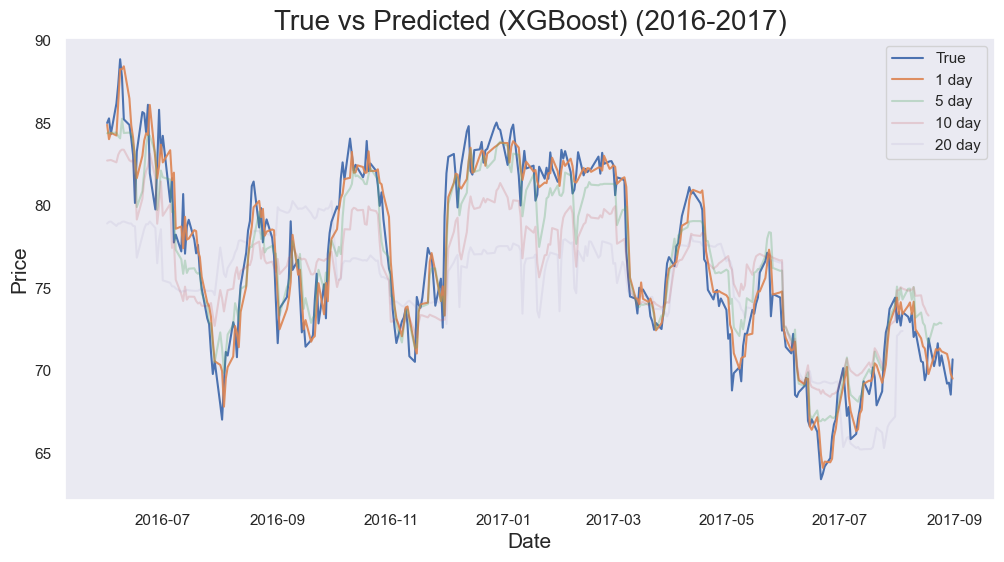

In [ ]:
model_outputs_up_to_september_2017 = []

full_df_processed_copy = full_df_processed.copy()
full_df_processed_copy = full_df_processed_copy.reset_index(drop=True)
start_index = full_df_processed_copy[full_df_processed_copy['Date'] == '2016-06-01'].index[0]
end_index = full_df_processed_copy[full_df_processed_copy['Date'] == '2017-09-01'].index[0]

full_X = full_df_processed_copy.drop(columns=['LogPercentChange', 'Date', 'Price'])
full_y = full_df_processed_copy['Price']

model_outputs_up_to_september_2017.append(
    {"model": "XGBoost", "horizon": 1, "mape^2": MAPE_squared(full_y.iloc[start_index:end_index], horizon_1_xgboost.predict(full_X.iloc[start_index:end_index])), "mape": MAPE(full_y.iloc[start_index:end_index], horizon_1_xgboost.predict(full_X.iloc[start_index:end_index])), "MSE" : mean_squared_error(full_y.iloc[start_index:end_index], horizon_1_xgboost.predict(full_X.iloc[start_index:end_index]))}
)

model_outputs_up_to_september_2017.append(
    {"model": "XGBoost", "horizon": 5, "mape^2": MAPE_squared(full_y.iloc[start_index+4:end_index], horizon_5_xgboost.predict(full_X.iloc[start_index:end_index - 4])), "mape": MAPE(full_y.iloc[start_index+4:end_index], horizon_5_xgboost.predict(full_X.iloc[start_index:end_index - 4])), "MSE" : mean_squared_error(full_y.iloc[start_index+4:end_index], horizon_5_xgboost.predict(full_X.iloc[start_index:end_index - 4]))}
)

model_outputs_up_to_september_2017.append(
    {"model": "XGBoost", "horizon": 10, "mape^2": MAPE_squared(full_y.iloc[start_index+9:end_index], horizon_10_xgboost.predict(full_X.iloc[start_index:end_index - 9])), "mape": MAPE(full_y.iloc[start_index+9:end_index], horizon_10_xgboost.predict(full_X.iloc[start_index:end_index - 9])), "MSE" : mean_squared_error(full_y.iloc[start_index+9:end_index], horizon_10_xgboost.predict(full_X.iloc[start_index:end_index - 9]))}
)

model_outputs_up_to_september_2017.append(
    {"model": "XGBoost", "horizon": 20, "mape^2": MAPE_squared(full_y.iloc[start_index+19:end_index], horizon_20_xgboost.predict(full_X.iloc[start_index:end_index - 19])), "mape": MAPE(full_y.iloc[start_index+19:end_index], horizon_20_xgboost.predict(full_X.iloc[start_index:end_index - 19])), "MSE" : mean_squared_error(full_y.iloc[start_index+19:end_index], horizon_20_xgboost.predict(full_X.iloc[start_index:end_index - 19]))}
)

# plot predictions over this period

plt.figure(figsize=(12, 6))
plt.plot(full_df_processed_copy['Date'].iloc[start_index:end_index], full_y.iloc[start_index:end_index], label='True')
plt.plot(full_df_processed_copy['Date'].iloc[start_index:end_index], horizon_1_xgboost.predict(full_X.iloc[start_index:end_index]), label='1 day', alpha=0.9)
plt.plot(full_df_processed_copy['Date'].iloc[start_index:end_index - 4], horizon_5_xgboost.predict(full_X.iloc[start_index:end_index - 4]), label='5 day', alpha=0.3)
plt.plot(full_df_processed_copy['Date'].iloc[start_index:end_index - 9], horizon_10_xgboost.predict(full_X.iloc[start_index:end_index - 9]), label='10 day', alpha=0.2)
plt.plot(full_df_processed_copy['Date'].iloc[start_index:end_index - 19], horizon_20_xgboost.predict(full_X.iloc[start_index:end_index - 19]), label='20 day', alpha=0.1)
plt.title('True vs Predicted (XGBoost) (2016-2017)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('figs/xgboost_blended_2016_2017.png', dpi=500)
plt.show()

100%|██████████| 317/317 [00:06<00:00, 49.04it/s]


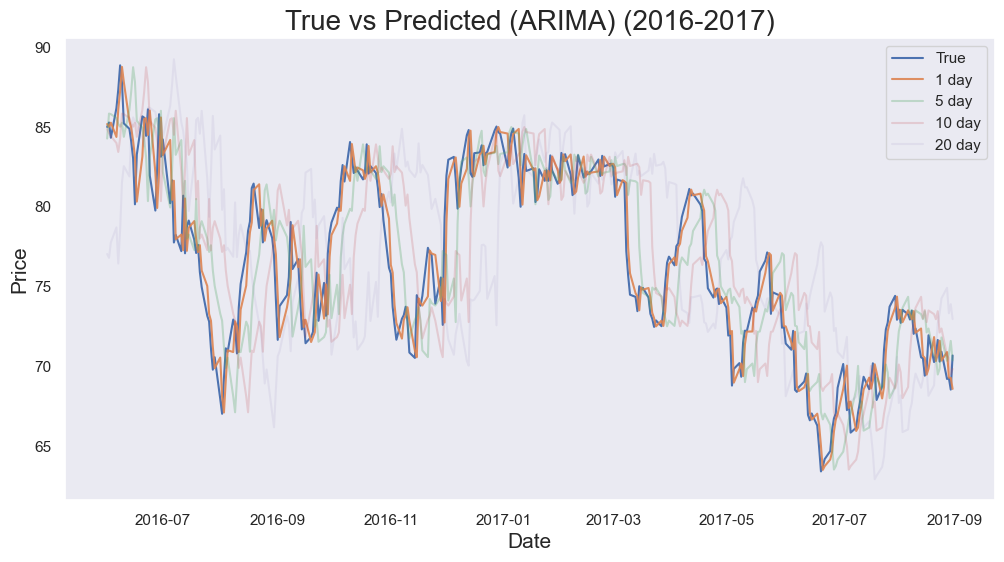

In [ ]:
full_df = full_df.copy()
full_df = full_df.reset_index(drop=True)

start_index = full_df[full_df['Date'] == '2016-06-01'].index[0]
end_index = full_df[full_df['Date'] == '2017-09-01'].index[0]

pseudo_train = full_df.iloc[:start_index]
pseudo_test = full_df.iloc[start_index:end_index]
pseudo_train = pseudo_train.reset_index(drop=True)
pseudo_test = pseudo_test.reset_index(drop=True)

arima_1_horizon_pred_pseudo = forecast_test(ARIMA_1_horizon, pseudo_train, pseudo_test, steps=1)
arima_5_horizon_pred_pseudo = forecast_test(ARIMA_5_horizon, pseudo_train, pseudo_test, steps=5)
arima_10_horizon_pred_pseudo = forecast_test(ARIMA_10_horizon, pseudo_train, pseudo_test, steps=10)
arima_20_horizon_pred_pseudo = forecast_test(ARIMA_20_horizon, pseudo_train, pseudo_test, steps=20)

model_outputs_up_to_september_2017.append(
    {"model": "ARIMA", "horizon": 1, "mape^2": MAPE_squared(pseudo_test['Price'], arima_1_horizon_pred_pseudo), "mape": MAPE(pseudo_test['Price'], arima_1_horizon_pred_pseudo), "MSE" : mean_squared_error(pseudo_test['Price'], arima_1_horizon_pred_pseudo)}
)

model_outputs_up_to_september_2017.append(
    {"model": "ARIMA", "horizon": 5, "mape^2": MAPE_squared(pseudo_test['Price'], arima_5_horizon_pred_pseudo), "mape": MAPE(pseudo_test['Price'], arima_5_horizon_pred_pseudo), "MSE" : mean_squared_error(pseudo_test['Price'], arima_5_horizon_pred_pseudo)}
)

model_outputs_up_to_september_2017.append(
    {"model": "ARIMA", "horizon": 10, "mape^2": MAPE_squared(pseudo_test['Price'], arima_10_horizon_pred_pseudo), "mape": MAPE(pseudo_test['Price'], arima_10_horizon_pred_pseudo), "MSE" : mean_squared_error(pseudo_test['Price'], arima_10_horizon_pred_pseudo)}
)

model_outputs_up_to_september_2017.append(
    {"model": "ARIMA", "horizon": 20, "mape^2": MAPE_squared(pseudo_test['Price'], arima_20_horizon_pred_pseudo), "mape": MAPE(pseudo_test['Price'], arima_20_horizon_pred_pseudo), "MSE" : mean_squared_error(pseudo_test['Price'], arima_20_horizon_pred_pseudo)}
)

# plot predictions over this period
plt.figure(figsize=(12, 6))
plt.plot(pseudo_test['Date'], pseudo_test['Price'], label='True')
plt.plot(pseudo_test['Date'], arima_1_horizon_pred_pseudo, label='1 day', alpha=0.9)
plt.plot(pseudo_test['Date'], arima_5_horizon_pred_pseudo, label='5 day', alpha=0.3)
plt.plot(pseudo_test['Date'], arima_10_horizon_pred_pseudo, label='10 day', alpha=0.2)
plt.plot(pseudo_test['Date'], arima_20_horizon_pred_pseudo, label='20 day', alpha=0.1)
plt.title('True vs Predicted (ARIMA) (2016-2017)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('figs/arima_blended_2016_2017.png', dpi=500)
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


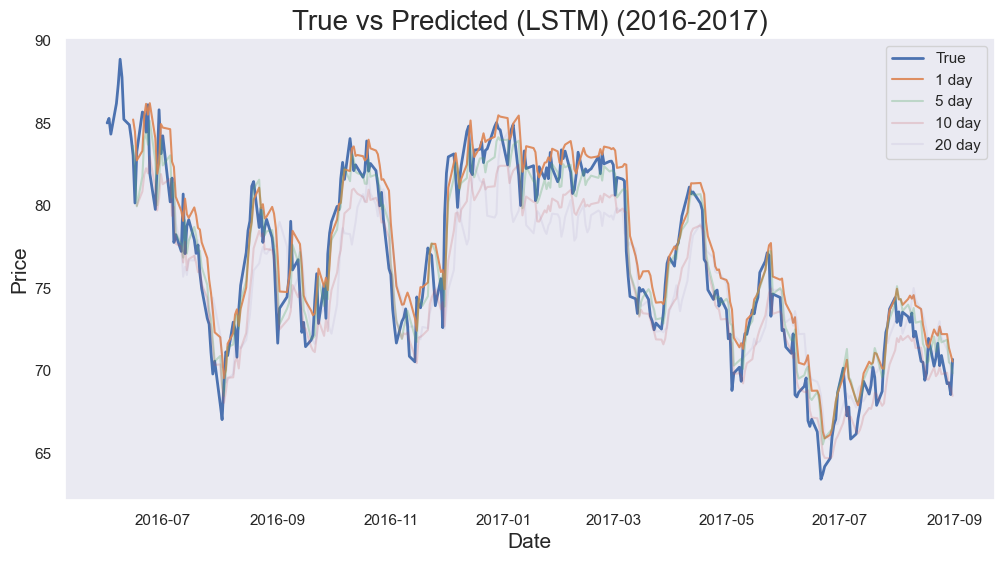

In [ ]:
# create sequences over this period
X_test_1_horizon_pseudo, y_test_1_horizon_pseudo = create_sequences(pseudo_test['Price'].values, look_back=horizon_1_look_back)
X_test_5_horizon_pseudo, y_test_5_horizon_pseudo = create_sequences(pseudo_test['Price'].values, look_back=horizon_5_look_back)
X_test_10_horizon_pseudo, y_test_10_horizon_pseudo = create_sequences(pseudo_test['Price'].values, look_back=horizon_10_look_back)
X_test_20_horizon_pseudo, y_test_20_horizon_pseudo = create_sequences(pseudo_test['Price'].values, look_back=horizon_20_look_back)

model_outputs_up_to_september_2017.append(
    {"model": "LSTM", "horizon": 1, "mape^2": MAPE_squared(y_test_1_horizon_pseudo, nn_1_horizon.predict(X_test_1_horizon_pseudo)), "mape": MAPE(y_test_1_horizon_pseudo, nn_1_horizon.predict(X_test_1_horizon_pseudo)), "MSE" : mean_squared_error(y_test_1_horizon_pseudo, nn_1_horizon.predict(X_test_1_horizon_pseudo))}
)
model_outputs_up_to_september_2017.append(
    {"model": "LSTM", "horizon": 5, "mape^2": MAPE_squared(y_test_5_horizon_pseudo, nn_5_horizon.predict(X_test_5_horizon_pseudo)), "mape": MAPE(y_test_5_horizon_pseudo, nn_5_horizon.predict(X_test_5_horizon_pseudo)), "MSE" : mean_squared_error(y_test_5_horizon_pseudo, nn_5_horizon.predict(X_test_5_horizon_pseudo))}
)
model_outputs_up_to_september_2017.append(
    {"model": "LSTM", "horizon": 10, "mape^2": MAPE_squared(y_test_10_horizon_pseudo, nn_10_horizon.predict(X_test_10_horizon_pseudo)), "mape": MAPE(y_test_10_horizon_pseudo, nn_10_horizon.predict(X_test_10_horizon_pseudo)), "MSE" : mean_squared_error(y_test_10_horizon_pseudo, nn_10_horizon.predict(X_test_10_horizon_pseudo))}
)
model_outputs_up_to_september_2017.append(
    {"model": "LSTM", "horizon": 20, "mape^2": MAPE_squared(y_test_20_horizon_pseudo, nn_20_horizon.predict(X_test_20_horizon_pseudo)), "mape": MAPE(y_test_20_horizon_pseudo, nn_20_horizon.predict(X_test_20_horizon_pseudo)), "MSE" : mean_squared_error(y_test_20_horizon_pseudo, nn_20_horizon.predict(X_test_20_horizon_pseudo))}
)

# plot predictions over this period
plt.figure(figsize=(12, 6))
plt.plot(pseudo_test['Date'], pseudo_test['Price'], label='True', linewidth=2)
plt.plot(pseudo_test['Date'].iloc[horizon_1_look_back:], nn_1_horizon.predict(X_test_1_horizon_pseudo), label='1 day', alpha=0.9)
plt.plot(pseudo_test['Date'].iloc[horizon_5_look_back:], nn_5_horizon.predict(X_test_5_horizon_pseudo), label='5 day', alpha=0.3)
plt.plot(pseudo_test['Date'].iloc[horizon_10_look_back:], nn_10_horizon.predict(X_test_10_horizon_pseudo), label='10 day', alpha=0.2)
plt.plot(pseudo_test['Date'].iloc[horizon_20_look_back:], nn_20_horizon.predict(X_test_20_horizon_pseudo), label='20 day', alpha=0.1)
plt.title('True vs Predicted (LSTM) (2016-2017)', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('figs/lstm_blended_2016_2017.png', dpi=500)
plt.show()

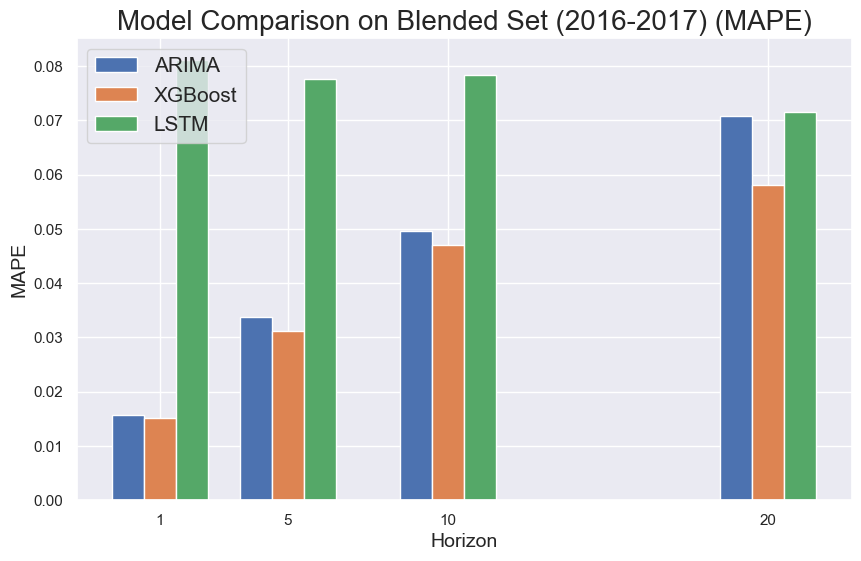

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_2017 = pd.DataFrame(model_outputs_up_to_september_2017)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_2017.pivot(index='horizon', columns='model', values='mape')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MAPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Blended Set (2016-2017) (MAPE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_blend_mape.png', dpi=500)
plt.show()


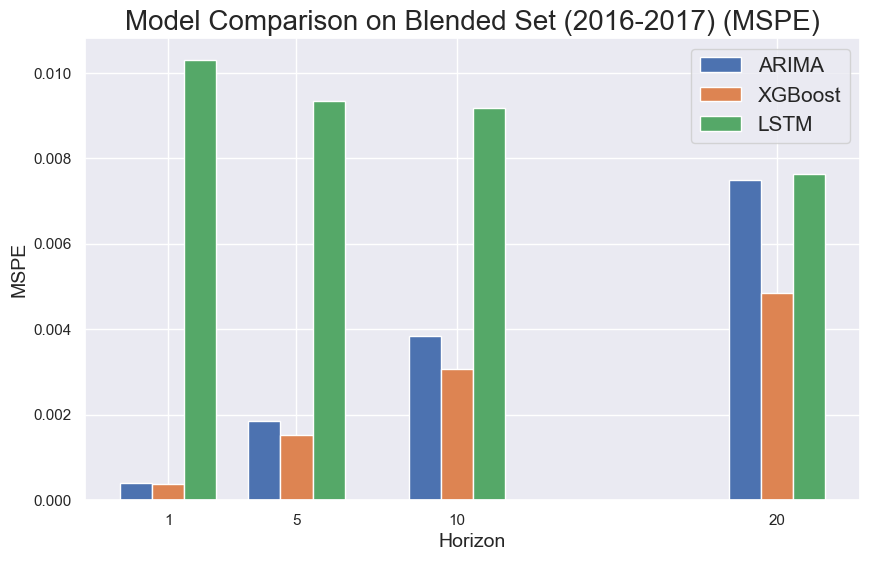

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_2017 = pd.DataFrame(model_outputs_up_to_september_2017)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_2017.pivot(index='horizon', columns='model', values='mape^2')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Blended Set (2016-2017) (MSPE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_blend_mspe.png', dpi=500)
plt.show()


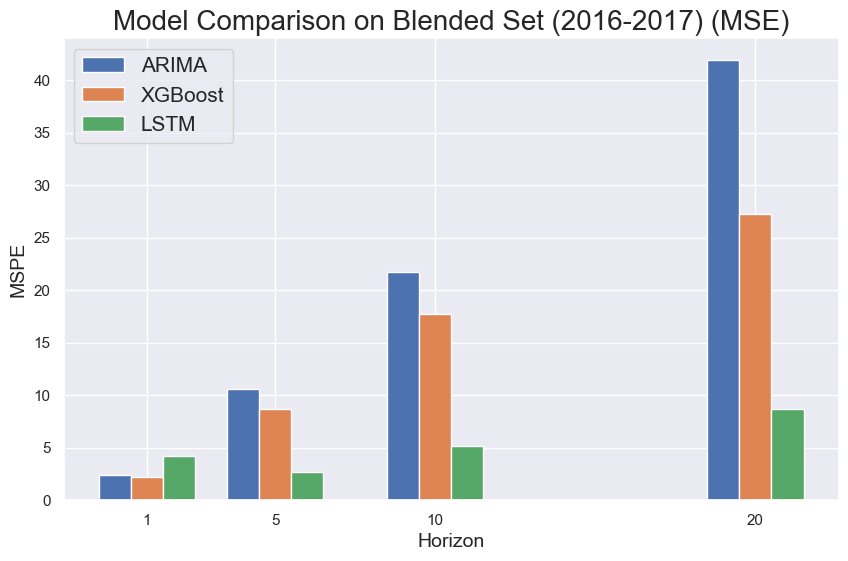

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
model_outputs_2017 = pd.DataFrame(model_outputs_up_to_september_2017)

# Pivot to get horizons as index and models as columns
pivot_df = model_outputs_2017.pivot(index='horizon', columns='model', values='MSE')

# Plot

x = pivot_df.index.tolist()
bar_width = 1

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([xi - bar_width for xi in x], pivot_df['ARIMA'], bar_width, label='ARIMA')
ax.bar([xi for xi in x], pivot_df['XGBoost'], bar_width, label='XGBoost')
ax.bar([xi + bar_width for xi in x], pivot_df['LSTM'], bar_width, label='LSTM')

ax.set_xlabel('Horizon', fontsize=14)
ax.set_ylabel('MSPE', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x)
# Add a title
ax.set_title('Model Comparison on Blended Set (2016-2017) (MSE)', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('figs/model_comparison_blend_mse.png', dpi=500)
plt.show()


In [ ]:
model_outputs_2017.to_csv('results/model_outputs_blend.csv', index=False)